In [1]:
import astropy.coordinates as coord
import numpy as np
from gala.units import UnitSystem
from yellowcard.model import TimingArgumentModel 
from yellowcard.coordinates import fiducial_m31_c
import astropy.units as u
from scipy.optimize import minimize
import emcee
import arviz as az

import matplotlib.pyplot as plt

In [2]:
# modelChoice = "vdm2012-radial"
# modelChoice = "vdm2012"
# modelChoice = "fiducial2021"
# modelChoice = "apw-simulated"
modelChoice = "apw-simulated-precise"

In [3]:
model = TimingArgumentModel.from_dataset(f"../datasets/{modelChoice}.ecsv")

In [4]:
init_par = {
    'lnr': np.log(711.91702),
    'lnM': np.log(3.8),
    'coseta': np.cos(4.3),
    'sineta': np.sin(4.3),
    'tperi': 14.524635,
    'cosalpha': np.cos(0.56548),
    'sinalpha': np.sin(0.56548),
    'eParam': np.log(1 - 0.981),
}

In [37]:
truths = {
    'r': 711.91702,
    'M': 3.8,
    'eta': 4.3,
    'tperi': 14.524635,
    'alpha': 0.56548,
    'e': 0.981,
    'a': 511,
    'vscale': 182.9,
    'vrad': -118,
    'vtan': 25.47,
    'sun_m31_dist': 707.9769
}

In [5]:
result = minimize( lambda *args: -model(*args)[0], model.pack_pars(init_par), method='Powell')
# result

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:2116: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)

/mnt/home/apricewhelan/anaconda3/lib/python3.7/site-packages/scipy/optimize/optimize.py:2117: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1



In [6]:
best_pars=model.unpack_pars(result.x)
# best_pars.update(model.transform_pars(model.unpack_pars(result.x)))
best_pars

{'lnr': array(6.56842802),
 'eParam': array(-3.99192057),
 'coseta': array(-0.40190599),
 'sineta': array(-0.91430278),
 'lnM': array(1.33778441),
 'cosalpha': array(0.03745708),
 'sinalpha': array(0.02368016)}

In [10]:
model.transform_pars(model.unpack_pars(result.x))['e']

0.9815357817224271

--- 
# r

In [40]:
lnlike_r = []
temp = best_pars.copy()

rSlice = np.linspace(700,720,1000)
lnrSlice = np.log(rSlice)

for lnr in lnrSlice:
    temp['lnr'] = lnr
    
    lnlike_r.append(model.ln_likelihood(temp)[0])

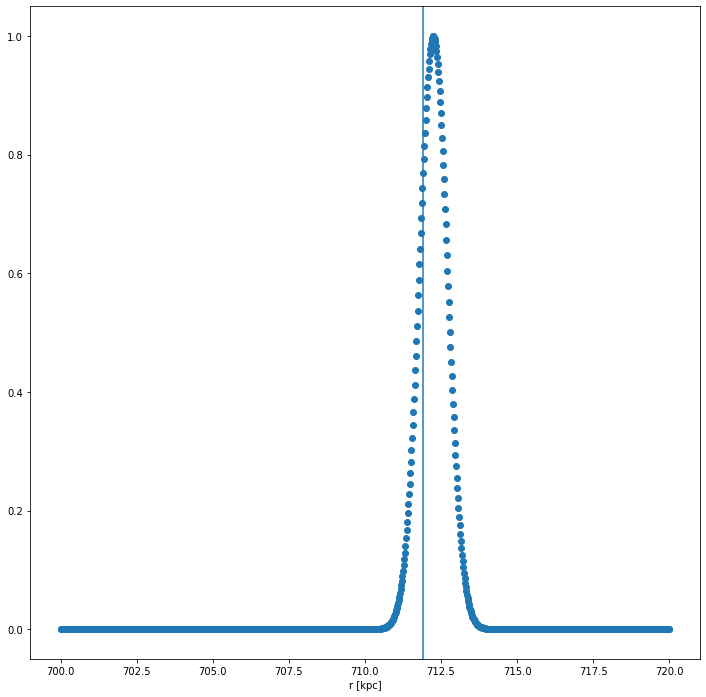

In [41]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(rSlice, np.exp(lnlike_r-np.max(lnlike_r)))
ax.set_xlabel(r"r [kpc]")
ax.axvline(truths['r'])
plt.show()

---
# $a$

In [48]:
lnlike_a = []
temp = best_pars.copy()

aSlice = np.linspace(505,520,1000)

for a in aSlice:
    ee = model.transform_pars(model.unpack_pars(result.x))['e']
    temp['lnr'] = np.log( a * (1 - ee * best_pars['coseta']))

    
    
    lnlike_a.append(model.ln_likelihood(temp)[0])

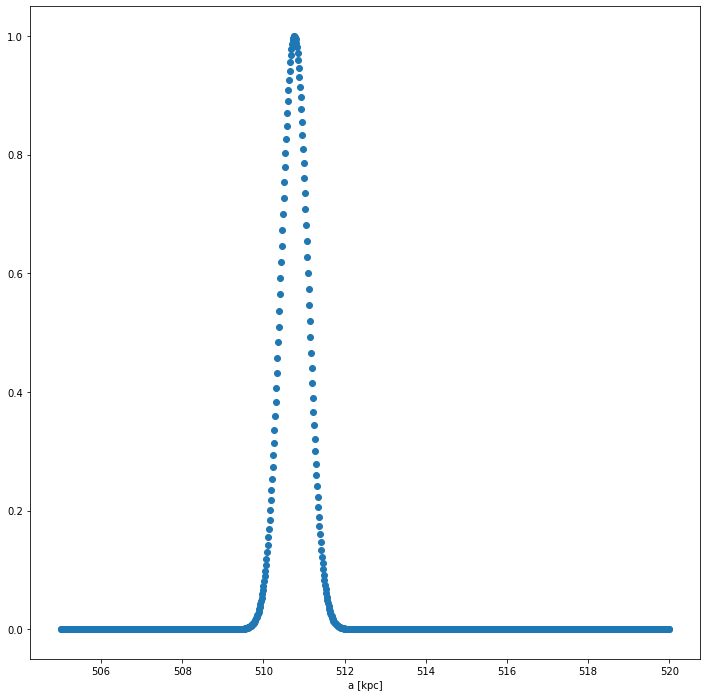

In [49]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(aSlice, np.exp(lnlike_a-np.max(lnlike_a)))
ax.set_xlabel(r"a [kpc]")
plt.show()

---
# $e$

In [50]:
lnlike_e = []
temp = best_pars.copy()

eSlice = np.linspace(0.97,0.99,1000)[:-1]
eParamSlice = np.log(1-eSlice)

for ePar in eParamSlice:
    temp['eParam'] = ePar
    
    lnlike_e.append(model.ln_likelihood(temp)[0])

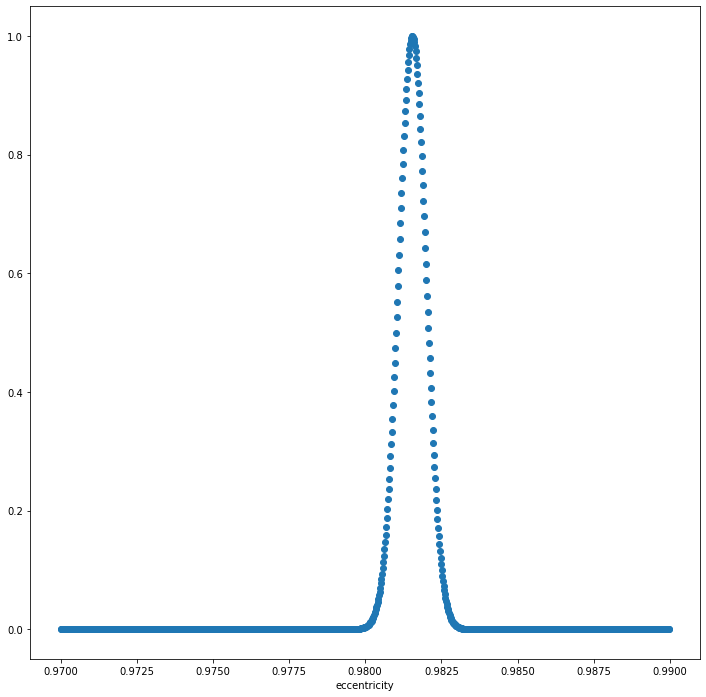

In [51]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(eSlice, np.exp(lnlike_e-np.max(lnlike_e)))
ax.set_xlabel(r"eccentricity")
plt.show()

---
# $M$

In [35]:
lnlike_M = []
temp = best_pars.copy()

MSlice = np.linspace(3.7,3.9,1000)
lnMSlice = np.log(MSlice)

for lnM in lnMSlice:
    temp['lnM'] = lnM
    
    lnlike_M.append(model.ln_likelihood(temp)[0])

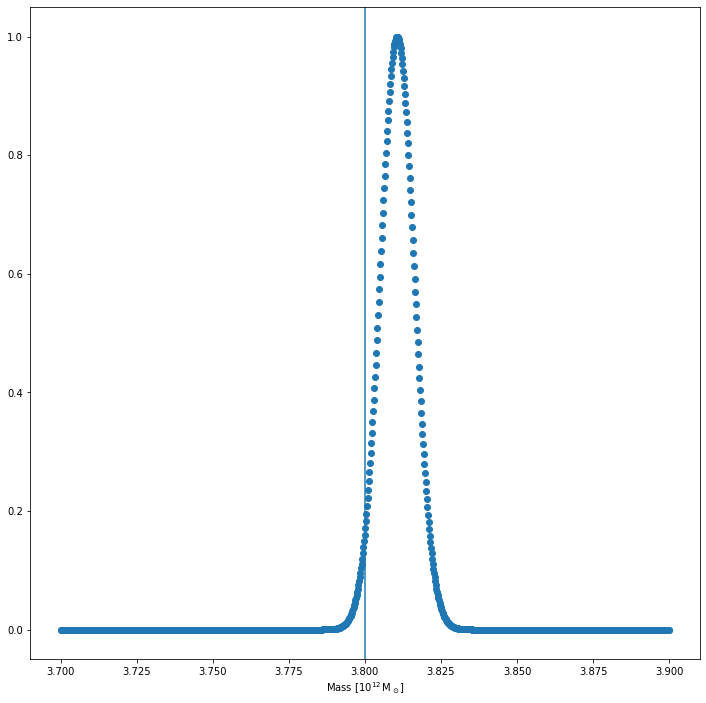

In [43]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(MSlice, np.exp(lnlike_M-np.max(lnlike_M)))
ax.set_xlabel(r"Mass [$10^{12}\, \rm M_\odot$]")
ax.axvline(truths['M'])
plt.show()

---
# $\eta$

In [52]:
lnlike_eta = []
temp = best_pars.copy()

etaSlice = np.linspace(4.28,4.31,1000)

for eta in etaSlice:
    temp['coseta'] = np.cos(eta)
    temp['sineta'] = np.sin(eta)
    
    lnlike_eta.append(model.ln_likelihood(temp)[0])

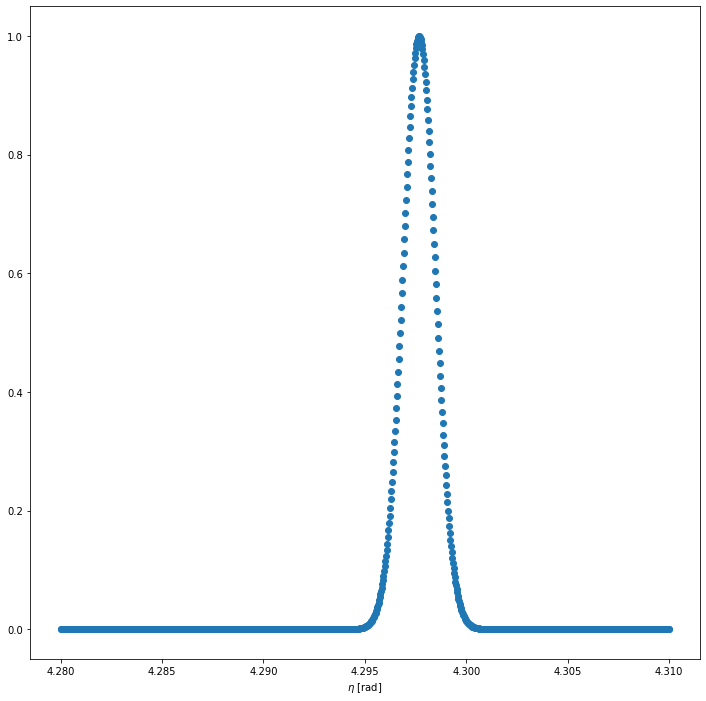

In [53]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(etaSlice, np.exp(lnlike_eta-np.max(lnlike_eta)))
ax.set_xlabel(r"$\eta$ [rad]")
plt.show()

---
# $\alpha$

In [54]:
lnlike_alpha = []
temp = best_pars.copy()

alphaSlice = np.linspace(0.4,0.7,1000)

for alpha in alphaSlice:
    temp['cosalpha'] = np.cos(alpha)
    temp['sinalpha'] = np.sin(alpha)
    
    lnlike_alpha.append(model.ln_likelihood(temp)[0])

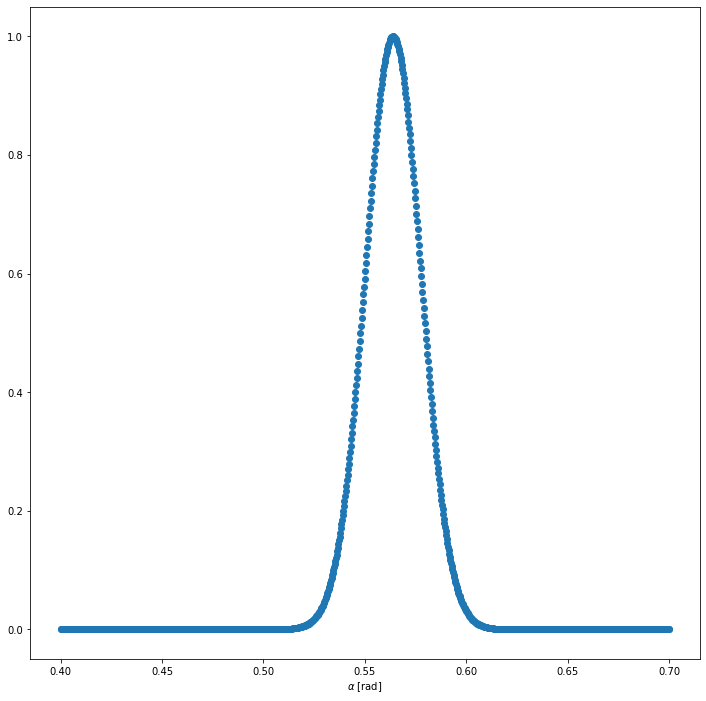

In [55]:
fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(alphaSlice, np.exp(lnlike_alpha-np.max(lnlike_alpha)))
ax.set_xlabel(r"$\alpha$ [rad]")
plt.show()

---
# plotting each parameter

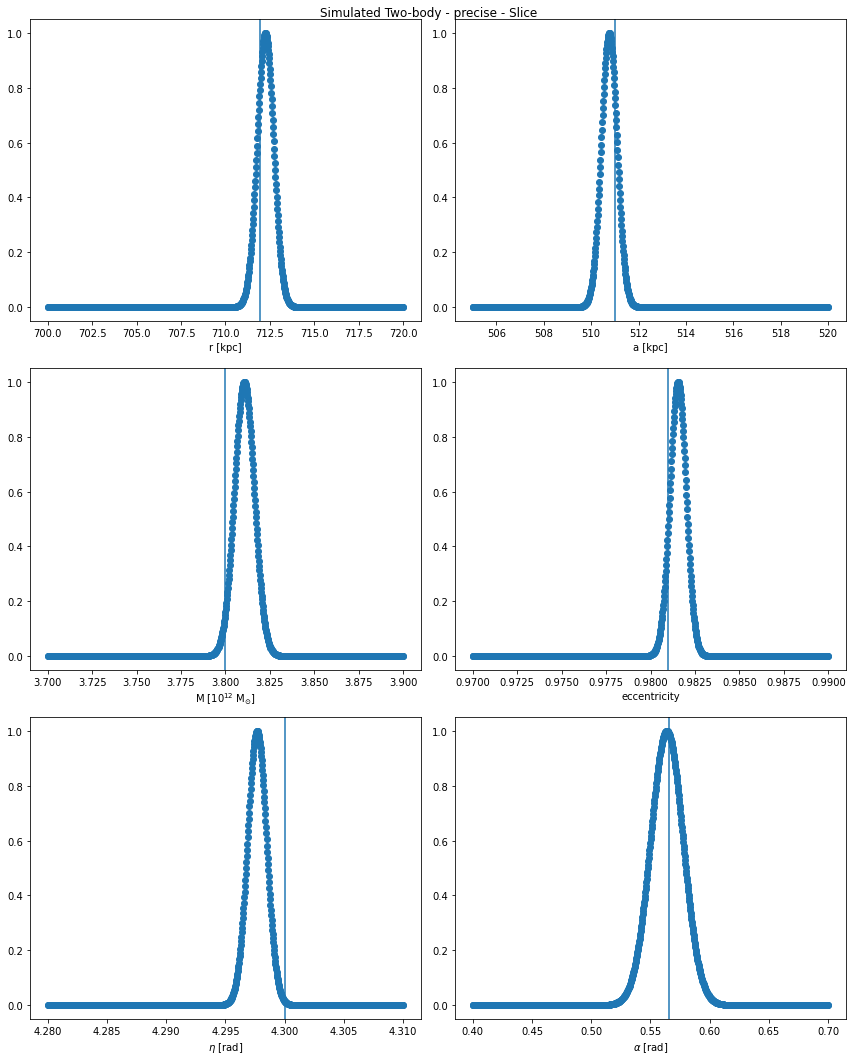

In [64]:
fig, ax = plt.subplots(3,2,figsize=(12,15))
# r
ax[0][0].scatter(rSlice, np.exp(lnlike_r-np.max(lnlike_r)))
ax[0][0].set_xlabel(r"r [kpc]")
ax[0][0].axvline(truths['r'])

# a
ax[0][1].scatter(aSlice, np.exp(lnlike_a-np.max(lnlike_a)))
ax[0][1].set_xlabel(r"a [kpc]")
ax[0][1].axvline(truths['r']/(1 - truths['e']*np.cos(truths['eta'])))

# M
ax[1][0].scatter(MSlice, np.exp(lnlike_M-np.max(lnlike_M)))
ax[1][0].set_xlabel(r"M [10$^{12}$ M$_{\odot}$]")
ax[1][0].axvline(truths['M'])

# e
ax[1][1].set_xlabel(r"eccentricity")
ax[1][1].scatter(eSlice, np.exp(lnlike_e-np.max(lnlike_e)))
ax[1][1].axvline(truths['e'])

# eta
ax[2][0].scatter(etaSlice, np.exp(lnlike_eta-np.max(lnlike_eta)))
ax[2][0].set_xlabel(r"$\eta$ [rad]")
ax[2][0].axvline(truths['eta'])

# alpha
ax[2][1].scatter(alphaSlice, np.exp(lnlike_alpha-np.max(lnlike_alpha)))
ax[2][1].set_xlabel(r"$\alpha$ [rad]")
ax[2][1].axvline(truths['alpha'])
fig.suptitle(f'{model.title} - Slice')
plt.tight_layout()
plt.savefig(f"../plots/{modelChoice}-slice.png",transparent=False,facecolor="white")
plt.show()